FC CASE

Remark: Difference of notations between this notebook and the article:

* "DG" stands for "DownGradient", scm_oce_dg is thus the 1D model for k-epsilon
* "DGNG" stands for "DownGradientNotGradient", scm_oce_dgng is thus the 1D model for ket

PS: For a better readability of the Notebook, please install the "jupyter_contrib_nbextensions" and activate the "Collapsible Headings" + "Codefolding" extensions.

In [1]:
#### --------------------------------------------------------------------
#### If you want to run the notebook, please specify the following paths 
#### --------------------------------------------------------------------

path_to_Fortran_modules = '/toto1/'     # location of the Fortran modules (1D model)
path_to_Fortran_modules = '/bettik/data-ocean/legaya/archives_James2024_ket_2ndSub/'     # location of the Fortran modules (1D model)
path_to_LES_data = '/toto2/'            # location of LES results
path_to_LES_data = '/bettik/data-ocean/legaya/archives_James2024_ket_2ndSub/'            # location of LES results

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import sys

sys.path.append(path_to_Fortran_modules + 'scm_oce_DG/')   
sys.path.append(path_to_Fortran_modules + 'scm_oce_DGNG/')
from scm_oce_DG import scm_oce_dg                 ### Fortran module for the 1D simulations
from scm_oce_DGNG import scm_oce_dgng             ### Fortran module for the 1D simulations

# Functions

In [3]:
def rhoNL (T,S):
    """Calculation of the density through a non-linear equation of state
    T in °C and S in g/kg (PSU)"""
    QR=+999.842594  ; Q01=+6.793952e-2;  Q02=-9.095290e-3;  
    Q03=+1.001685e-4; Q04=-1.120083e-6;  Q05=+6.536332e-9;  
    Q10=+0.824493   ; Q11=-4.08990e-3 ;  Q12=+7.64380e-5;   
    Q13=-8.24670e-7 ; Q14=+5.38750e-9 ;  QS0=-5.72466e-3;   
    QS1=+1.02270e-4 ; QS2=-1.65460e-6 ;  Q20=+4.8314e-4;
    
    sqrtS   = np.sqrt(S)
    rho =   QR+T*(Q01+T*(Q02+T*(Q03+T*(Q04+T*Q05)))) \
             +S*(Q10+T*(Q11+T*(Q12+T*(Q13+T*Q14)))    \
             +sqrtS*(QS0+T*(QS1+T*QS2))+S*Q20)
    return(rho)

def glsMin(tke_min, eps_min, turbulence_scheme, stability_function):
    """Calculations of the minimal "psi" corresponding to the given minimal turbulent kinetic 
    energy and given minimal dissipation"""
    rp = rm = rn = 0.0        
    if   turbulence_scheme == 1:
        rp = -1.0 ; rm = 0.5  ; rn = -1.0
    elif turbulence_scheme == 2:
        rp = 3.0  ; rm = 1.5  ; rn = -1.0
    elif turbulence_scheme == 3:
        rp = 0.0  ; rm = 1.0  ; rn = -0.67 
    
    c1=5.; c2=0.8; c3=1.968; c4=1.136
    if   stability_function == 1:
        c1=3.6; c2=0.8;    c3=1.2;    c4=1.2
    elif stability_function == 2:
        c1=6.;  c2=0.32;   c3=0.;     c4=0.
    elif stability_function == 3:
        c1=6.;  c2=0.32;   c3=0.;     c4=0.
    elif stability_function == 4:
        c1=3.;  c2=0.8;    c3=2.;     c4=1.118
    elif stability_function == 5:
        c1=5.;  c2=0.6983; c3=1.9664; c4=1.094
    elif stability_function == 6:          
        c1=5.;  c2=0.7983; c3=1.968;  c4=1.136    

    nn  = 0.5*c1
    a1  = 0.66666666667-0.5*c2
    a2  = 1.-0.5*c3
    a3  = 1.-0.5*c4            
    cm0 =  pow( (a2*a2 - 3.0*a3*a3 + 3.0*a1*nn)/(3.0*nn*nn), 0.25 )     
    cff     = pow(cm0,3) * pow(tke_min,1.5) / eps_min                     
    gls_min = pow(cm0,rp) * pow(tke_min,rm) * pow(cff,rn) 
    return(gls_min)

def autoscale(ax=None, axis='x', margin=0.05):
    '''Autoscales the x or y axis of a given matplotlib ax object
    to fit the margins set by manually limits of the other axis,
    with margins in fraction of the width of the plot
    
    Defaults to current axes object if not specified.
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    if ax is None:
        ax = plt.gca()
    newlow, newhigh = np.inf, -np.inf

    for artist in ax.collections + ax.lines:
        x,y = get_xy(artist)
        if axis == 'y':
            setlim = ax.set_ylim
            lim = ax.get_xlim()
            fixed, dependent = x, y
        else:
            setlim = ax.set_xlim
            lim = ax.get_ylim()
            fixed, dependent = y, x

        low, high = calculate_new_limit(fixed, dependent, lim)
        newlow = low if low < newlow else newlow
        newhigh = high if high > newhigh else newhigh

    margin = margin*(newhigh - newlow)

    setlim(newlow-margin, newhigh+margin)
    
def calculate_new_limit(fixed, dependent, limit):
    '''Calculates the min/max of the dependent axis given 
    a fixed axis with limits
    '''
    if len(fixed) > 2:
        mask = (fixed>limit[0]) & (fixed < limit[1])
        window = dependent[mask]
        low, high = window.min(), window.max()
    else:
        low = dependent[0]
        high = dependent[-1]
        if low == 0.0 and high == 1.0:
            # This is a axhline in the autoscale direction
            low = np.inf
            high = -np.inf
    return low, high

def get_xy(artist):
    '''Gets the xy coordinates of a given artist
    '''
    if "Collection" in str(artist):
        x, y = artist.get_offsets().T
    elif "Line" in str(artist):
        x, y = artist.get_xdata(), artist.get_ydata()
    else:
        raise ValueError("This type of object isn't implemented yet")
    return x, y

# Parameters for the 1D simulations

In [4]:
#%%  INITIALISATION

#====================
# Input parameters
#====================

# Physical parameters ===========================================================
cp            = 3985    # specific heat [J/kg/K] 
dpdx          = 0.      # barotropic pressure gradient [m/s2]
r_D           = 0.      # bottom friction  CD * ||ubot||
Zob           = 0.      # bottom rugosity length
Neu_bot       = True    # bottom boundary condition 
lin_eos       = True            # type of the equation of state
T0            = 20              # surface temperature of the initial profile [C]
S0            = 35              # constant salinity along the profile [psu]
rho0          = rhoNL(T0,S0)    # reference density [kg/m3]
alpha         = 2e-4            # coeff for NG term + if lin_eos = True, coef of the eos for the temperature [1/C]  
beta          = 8e-4            # if lin_eos = True. Coef of the eos for the salinity [1/psu]  
nuwm          = 1.0e-4          # minimal value of the turbulent viscosity 
nuws          = 0.1e-4          # minimal value of the turbulent diffusivity 
fcor          = 0               # coriolis parameter [1/s]

### You need to fix N2 or dTdz0
N2            = 'Calculated'          # Brunt Vaisala frequency (diagnostic) [s-2]
dTdz0         = 0.01    # initial temperature gradient [C/m] 

if N2 == 'Calculated':
    N2        = dTdz0*alpha*9.81  # Brunt Vaisala frequency (diagnostic) [s-2]
elif dTdz0 == 'Calculated':
    dTdz0     = N2/9.81/alpha            # initial temperature gradient [C/m] 
else:
    raise ValueError("You can't fix N2 and dTdz0 at the same time")

# Spatial and temporal grids ====================================================
nz            = 512     # nb of vertical points
hmax          = 100.    # total depth of the domain [m] 
dt            = 360.    # time step [s]
dt_out        = 3600.      # output time step [s]
output_period = int(dt_out/dt)         # storage every x time steps
total_time    = 7*24*3600+1*3600             # total simulation time [s]
nb_steps      = int(total_time/dt)     # nb of time steps
ntra          = 2       # nb of tracers : 2 (temperature + salinity)
nt            = 2       # nb of time steps stored : 2 (n et n+1)
ngls          = 2       # nb of variable for GLS closure : 2 (TKE + GLS)  

In [5]:
#======================================================
#           Definition of the vertical grid
#======================================================
z_r    = np.zeros(nz)
z_w    = np.zeros(nz+1)
Hz     = np.zeros(nz)   
z_w[0] = -hmax
ds  = 1./nz
for k in range(nz,0,-1):
    sc_w     = ds * float(k-nz)
    z_w[k  ] = hmax*sc_w
    sc_r     = ds*(float(k-nz)-0.5)
    z_r[k-1] = hmax*sc_r
for k in range(nz):
    Hz[k] = z_w[k+1]-z_w[k]

In [6]:
#======================================================
#                Initial profiles 
#======================================================
T_initial = np.zeros(nz); S_initial = np.zeros(nz)
for k in range(nz):
    T_initial[k] = T0 - dTdz0*np.abs(z_r[k])
    S_initial[k] = S0

In [7]:
ustar           = 0.                                    # friction velocity [m/s]
tauy            = 0.                                    # meridional wind stress [N.m-2] 
tauy_m2s2       = tauy/rho0                             # meridional wind stress [m2/s2]
taux            = np.sqrt((ustar**2*rho0)**2 - tauy**2) # zonal wind stress [N.m-2] 
taux_m2s2       = taux/rho0                             # zonal wind stress [m2/s2] 

fnonsol     = -75                                       # non solar flux at the surface [W/m2]
EmP         = 0                                         # evaporation - precipitation [kg.m-2.s-1] = [mm.s-1]
freshflx    = EmP * S0 / rho0                           # fresh water flux (opposite of this flux to be precise) [psu.m/s]
fsol        = 0.                                        # solar flux [W/m^2]
fsol_Cms    = fsol / (rho0*cp)                          # solar flux [°C.m/s]
fnet   = fnonsol + fsol                                 # net heat fux [W/m2]
fnet_Cms = fnet / (rho0*cp)                             # net heat fux  [°C.m/s]
B0   = 9.81/rho0 * (alpha/cp * fnet - EmP * S0 * beta)  # buoyancy flux [m2/s3]


# Performing the 1D simulations

In [8]:
#===============================================
# Initialisation of output variables
#===============================================

N_sch        = 4
# Number of schemes run
# Choose which ones at the end of the cell
    
n_sch        = -1                               # index of the current model
nout         = int((nb_steps-1)/output_period+1)  # nb of points stored
t_days       = np.zeros(nout)                   # output moments
T            = np.zeros((nz,nout,N_sch))        # T array
varT         = np.zeros((nz+1,nout,N_sch))      # varT array
Kt           = np.zeros((nz+1,nout,N_sch))      # diffusion coeff for scalar
Gamma_ket    = np.zeros((nz+1,nout,N_sch))      # ket non-local term of 
wT_NL_KPP    = np.zeros((nz+1,nout))            # KPP non-local term
TKE          = np.zeros((nz+1,nout,N_sch))      # turbulent kinetic energy
Eps          = np.zeros((nz+1,nout,N_sch))      # dissip epsilon with eps(0) and eps(N) put to 0
Fh           = np.zeros((nz+1,nout,N_sch))      # stab function for diffusive part of wT 
Fh_star      = np.zeros((nz+1,nout,N_sch))      # stab function for non-local term of wT
Alpha_n      = np.zeros((nz+1,nout,N_sch))      # Relative to the stratification (Coeff in stability functions)


### K-epsilon DG

In [9]:
# ===========    k-epsilon model    =================
    
ncount             = 0     # storage counter during the simulation
turbulence_scheme  = 2     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS, "0" = Canuto A
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1
i_Keps_DG          = n_sch
EVD                = False   
NonLocalKPP        = True  # Not relevant here but needed to be given

# ===================================
# Initial condition definition
# ===================================

uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F')  

for t in range(nt):
    toce[:,t,0] = T_initial    # initialisation of the temperature profile
    toce[:,t,1] = S_initial    # initialisation of the salinity profile
    
rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = np.array(0.)               # initialisation of the MLD
# Remark1: do not need to give the actual MLD since it is re-calculated before being used 
# Remark2: very important to give a one-element array and not a scalar, otherwise the Fortran routine
# cannot change it and hbls keep the same value during all the simulation...
    

# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     

# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = + dTdz0       # = the initial temperature vertical gradient [Celsius/m]
dTdz_bot[1]  = 0.            # no flux for the salinity [psu/m]


# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================

Akm  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akm [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akm [0] = Akm [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   

tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
fm = np.zeros(nz+1)
fh = np.zeros(nz+1)
alpha_n = np.zeros(nz+1)
alpha_m = np.zeros(nz+1)

#===============================================                   
# Temporal loop
#===============================================  
for kt in range(nb_steps):
    time = dt*float(kt)       # time in s

    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False

    # temporal integration                                          
    scm_oce_dg.obl_stp_dg(z_r,z_w,Hz,                                     \
                    unudge,vnudge,tnudge,                                   \
                    uoce,voce,toce,turb,lmix,eps,                           \
                    rho0,rho1,Akm,Akt,wx_NL_KPP,fm,fh,alpha_n,    \
                    alpha_m,r_D,taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,      \
                    freshflx,dTdz_bot,delta,fcor,Ric,hbls,                  \
                    dt,dpdx,turbulence_scheme,stability_function,           \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,NonLocalKPP,   \
                    check_inputs,kt,nstp,nnew,nz,ntra,nt,ngls)
    
    time_nnew   = time + dt
    
    # if it is a storage moment
    if  kt % output_period == 0:
        t_days [ncount]      = time_nnew / (24. * 3600.)              # current time in day        
        Kt[:,ncount,n_sch]   = Akt[:,0]          # diffusivity storage
        T[:,ncount,n_sch]    = toce[:,nnew-1,0]  # temperature storage
        
        TKE[:,ncount,n_sch]  = turb[:,nnew-1,0]  # TKE storage
        Eps[:,ncount,n_sch]  = eps               # dissipation storage
        ncount = ncount + 1   

#===============================================  
del uoce, voce, toce, turb, Akm, Akt      


 cm0      =   0.52646469697902432     
 alpha_n_min      =   -3.1426048370860973     
 alpha_m_max      =    73.768869835225601     
 keps_DG


### K-epsilon DGNG

In [10]:
# ===========    ket model    =================

ncount             = 0     # storage counter during the simulation
turbulence_scheme  = 2     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS, "0" = Canuto A
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1
i_Keps_DGNG        = n_sch
EVD                = False   
NonLocalKPP        = True  # Not relevant here but needed to be given
printXinfo         = 0.

# ===================================
# Initial condition definition
# ===================================

uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F') 
varToce  = np.zeros((nz+1,nt), order='F')  

for t in range(nt):
    toce[:,t,0] = T_initial    # initialisation of the temperature profile
    toce[:,t,1] = S_initial    # initialisation of the salinity profile
    
rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = np.array(0.)               # initialisation of the MLD
# Remark1: do not need to give the actual MLD since it is re-calculated before being used 
# Remark2: very important to give a one-element array and not a scalar, otherwise the Fortran routine
# cannot change it and hbls keep the same value during all the simulation...
    

# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     

# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = + dTdz0       # = the initial temperature vertical gradient [Celsius/m]
dTdz_bot[1]  = 0.            # no flux for the salinity [psu/m]

# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================

Akm  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akm [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akm [0] = Akm [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   
gamma_ket = np.zeros(nz+1)

tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
fm = np.zeros(nz+1)
fh = np.zeros(nz+1)
fh_star = np.zeros(nz+1)
alpha_n = np.zeros(nz+1)
alpha_m = np.zeros(nz+1)
alpha_v = np.zeros(nz+1)
n2 = np.zeros(nz+1)

#===============================================                   
# Temporal loop
#===============================================  
for kt in range(nb_steps):
    time = dt*float(kt)       # time in s

    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False
        
    # temporal integration                                          
    scm_oce_dgng.obl_stp_dgng(z_r,z_w,Hz,                      \
                    unudge,vnudge,tnudge,                                \
                    uoce,voce,toce,varToce,n2,turb,lmix,eps,                \
                    rho0,rho1,Akm,Akt,gamma_ket,wx_NL_KPP,fm,          \
                    fh,fh_star,                            \
                    alpha_n,alpha_m,alpha_v,r_D,                         \
                    taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,freshflx,      \
                    dTdz_bot,delta,fcor,Ric,hbls,                        \
                    dt,dpdx,turbulence_scheme,stability_function,        \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,            \
                    NonLocalKPP,check_inputs,kt,nstp,nnew,nz,ntra,nt,ngls)
    
    # if it is a storage moment
    if  kt % output_period == 0:
        Kt[:,ncount,n_sch]         = Akt[:,0]          # diffusivity storage
        Gamma_ket[:,ncount,n_sch]  = gamma_ket      
        T[:,ncount,n_sch]          = toce[:,nnew-1,0]  # temperature storage
        varT[:,ncount,n_sch]       = varToce[:,nnew-1] # temperature variance storage
       
        TKE[:,ncount,n_sch]  = turb[:,nnew-1,0]  # TKE storage
        Eps[:,ncount,n_sch]  = eps               # dissipation storage
        Fh[:,ncount,n_sch] = fh                  # stab function storage (diffusive part of wT)
        Fh_star[:,ncount,n_sch] = fh_star        # stab function storage (non-local term of wT)
        Alpha_n[:,ncount,n_sch] = alpha_n
        
        ncount = ncount + 1      
        
#===============================================  
del uoce, voce, toce, turb, Akm, Akt      


 cm0              =   0.52646469697902432     
 alpha_n_min      =   -6.3750000000000009     
 alpha_m_max      =    109.35655706204348     
 alpha_bT_max      =    4.6594009577347768E-310
 keps_DGNG


### KPP

In [11]:
# ===========   KPP model   =================


ncount             = 0     # storage counter during the simulation
turbulence_scheme  = 4     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS (1,2,3)
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1 
i_KPP              = n_sch
NonLocalKPP        = True    # Activation of the non-local term
EVD                = False   # Not relevant here but needed to be given
printXinfo         = 0.

# ===================================
# Initial condition definition
# ===================================

uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F') 
varToce  = np.zeros((nz+1,nt), order='F')  

for t in range(nt):
    toce[:,t,0] = T_initial    # initialisation of the temperature profile
    toce[:,t,1] = S_initial    # initialisation of the salinity profile
    
rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = np.array(0.)               # initialisation of the MLD
# Remark1: do not need to give the actual MLD since it is re-calculated before being used 
# Remark2: very important to give a one-element array and not a scalar, otherwise the Fortran routine
# cannot change it and hbls keep the same value during all the simulation...
    

# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     

# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = + dTdz0       # = the initial temperature vertical gradient [Celsius/m]
dTdz_bot[1]  = 0.            # no flux for the salinity [psu/m]

# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================

Akm  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akm [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akm [0] = Akm [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   
gamma_ket = np.zeros(nz+1)   

tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
fm = np.zeros(nz+1)
fh = np.zeros(nz+1)
fh_star = np.zeros(nz+1)
alpha_n = np.zeros(nz+1)
alpha_m = np.zeros(nz+1)
alpha_v = np.zeros(nz+1)
n2 = np.zeros(nz+1)

#===============================================                   
# Temporal loop
#===============================================  
for kt in range(nb_steps):
    time = dt*float(kt)       # time in s

    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False
   
    # temporal integration                                          
    scm_oce_dgng.obl_stp_dgng(z_r,z_w,Hz,                                \
                    unudge,vnudge,tnudge,                                \
                    uoce,voce,toce,varToce,n2,turb,lmix,eps,             \
                    rho0,rho1,Akm,Akt,gamma_ket,wx_NL_KPP,fm,          \
                    fh,fh_star,                          \
                    alpha_n,alpha_m,alpha_v,r_D,                         \
                    taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,freshflx,      \
                    dTdz_bot,delta,fcor,Ric,hbls,                        \
                    dt,dpdx,turbulence_scheme,stability_function,        \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,            \
                    NonLocalKPP,check_inputs,kt,nstp,nnew,nz,ntra,nt,ngls)
    
    # if it is a storage moment
    if  kt % output_period == 0:
        Kt[:,ncount,n_sch]         = Akt[:,0]          # diffusivity storage      
        T[:,ncount,n_sch]          = toce[:,nnew-1,0]  # temperature storage
        ncount = ncount + 1      
    
#===============================================  
del uoce, voce, toce, turb, Akm, Akt  


### KPP without NL

In [12]:
# ===========   KPP model without its non-local term  =================


ncount             = 0     # storage counter during the simulation
turbulence_scheme  = 4     # 0 KPP05, 1 K-omega, 2 K-eps, 3 gen, 4 KPP94, 5 TKE 
stability_function = 0     # only for GLS (1,2,3)
Ric                = 0.3   # must be between 0.15 and 0.45
n_sch              = n_sch + 1 
i_KPPwoNL          = n_sch
NonLocalKPP        = False    # Activation of the non-local term
EVD                = False   # Not relevant here but needed to be given
printXinfo         = 0.

# ===================================
# Initial condition definition
# ===================================

uoce  = np.zeros((nz,nt), order='F')       # initial u = 0
voce  = np.zeros((nz,nt), order='F')       # initial v = 0
toce  = np.zeros((nz,nt,ntra), order='F') 
varToce  = np.zeros((nz+1,nt), order='F')  

for t in range(nt):
    toce[:,t,0] = T_initial    # initialisation of the temperature profile
    toce[:,t,1] = S_initial    # initialisation of the salinity profile
    
rho1  = np.zeros(nz)               # initialisation of the size of the density array
hbls  = np.array(0.)               # initialisation of the MLD
# Remark1: do not need to give the actual MLD since it is re-calculated before being used 
# Remark2: very important to give a one-element array and not a scalar, otherwise the Fortran routine
# cannot change it and hbls keep the same value during all the simulation...
    

# =========================================================
# Definition of a large scale forcing with a restoring time 
# delta. Ignored if delta = 0.
# =========================================================
unudge = np.zeros( nz )    # no geostrophic current u
vnudge = np.zeros( nz )    # no geostrophic current v
tnudge = np.zeros((nz,ntra), order='F')
delta  = np.zeros((nz,ntra), order='F')     

# bottom boundary condition for T and S
dTdz_bot     = np.zeros(ntra)
dTdz_bot[0]  = + dTdz0       # = the initial temperature vertical gradient [Celsius/m]
dTdz_bot[1]  = 0.            # no flux for the salinity [psu/m]

# =========================================================
# Initialisation of the parameters of the turbulent closure
# =========================================================

Akm  = np.zeros(nz+1)  
Akt  = np.zeros((nz+1,ntra), order='F')   
Akm [:]     = nuwm
Akt [:,0]   = nuws
Akt [:,1]   = nuws    
Akm [0] = Akm [nz] = 0.
Akt [0,0] = Akt [nz,0] = Akt [0,0] = Akt [nz,0] = 0.
wx_NL_KPP = np.zeros((nz+1,ntra), order='F')   
gamma_ket = np.zeros(nz+1)   

tke_min = 1.e-6
eps_min = 1.e-12
turb = np.zeros((nz+1,2,ntra), order='F')
turb[:,:,0] = tke_min
turb[:,:,1] = glsMin(tke_min, eps_min, turbulence_scheme, stability_function)
lmix = np.zeros(nz+1)
eps  = np.zeros(nz+1)
fm = np.zeros(nz+1)
fh = np.zeros(nz+1)
fh_star = np.zeros(nz+1)
alpha_n = np.zeros(nz+1)
alpha_m = np.zeros(nz+1)
alpha_v = np.zeros(nz+1)
n2 = np.zeros(nz+1)

#===============================================                   
# Temporal loop
#===============================================  
for kt in range(nb_steps):
    time = dt*float(kt)       # time in s

    nstp = 1 +  kt    % 2     # moment "n", = 1 or 2 (fortran index), python index = nstp-1 
    nnew = 1 + (kt+1) % 2     # # moment "n+1", = 1 or 2 (fortran index), python index = nnew-1
    check_inputs = False
   
    # temporal integration                                          
    scm_oce_dgng.obl_stp_dgng(z_r,z_w,Hz,                                \
                    unudge,vnudge,tnudge,                                \
                    uoce,voce,toce,varToce,n2,turb,lmix,eps,             \
                    rho0,rho1,Akm,Akt,gamma_ket,wx_NL_KPP,fm,          \
                    fh,fh_star,                          \
                    alpha_n,alpha_m,alpha_v,r_D,                         \
                    taux_m2s2,tauy_m2s2,fsol_Cms,fnet_Cms,freshflx,      \
                    dTdz_bot,delta,fcor,Ric,hbls,                        \
                    dt,dpdx,turbulence_scheme,stability_function,        \
                    lin_eos,alpha,T0,beta,S0,Zob,Neu_bot,EVD,            \
                    NonLocalKPP,check_inputs,kt,nstp,nnew,nz,ntra,nt,ngls)
    
    # if it is a storage moment
    if  kt % output_period == 0:
        Kt[:,ncount,n_sch]         = Akt[:,0]          # diffusivity storage
        T[:,ncount,n_sch]          = toce[:,nnew-1,0]  # temperature storage
        ncount = ncount + 1      
    
#===============================================  
del uoce, voce, toce, turb, Akm, Akt  


# Post-processing and LES opening

In [13]:
dTdz = np.zeros((nz+1,nout,N_sch))
for s in range(N_sch):    
    for k in range(nz):
        dTdz[k,:,s] = (T[k,:,s] - T[k-1,:,s])/(z_r[k] - z_r[k-1])  
    dTdz[0,:,s] = dTdz[1,:,s]
    dTdz[-1,:,s] = dTdz[-2,:,s]

wT_DG = - Kt * dTdz
wT_NG = np.zeros((nz+1,nout,N_sch))
wT_NG[:,:,i_KPP]       = wT_NL_KPP
wT_NG[:,:,i_Keps_DGNG] = Gamma_ket[:,:,i_Keps_DGNG]
wT = wT_DG + wT_NG

t_seconds = t_days*3600*24
t_hours = t_days*24

z_r_N_sch = np.repeat(z_r[:, np.newaxis], N_sch, axis=1)   # z_r repeated "N_sch" times on a new dimension
z_w_N_sch = np.repeat(z_w[:, np.newaxis], N_sch, axis=1)   # z_w repeated "N_sch" times on a new dimension


In [14]:
Eps[Eps == 0] = 1e-12   # for avoiding divisions by 0
TKE[TKE == 0] = 1e-6    # for avoiding divisions by 0
cT = 1.44

varT[:,:,i_Keps_DG] = cT * TKE[:,:,i_Keps_DG]/Eps[:,:,i_Keps_DG] * Kt[:,:,i_Keps_DG] * (dTdz[:,:,i_Keps_DG])**2
varT[0,:,i_Keps_DG] = varT[1,:,i_Keps_DG]
varT[-1,:,i_Keps_DG] = varT[-2,:,i_Keps_DG]
varT[-1,:,i_Keps_DGNG] = varT[-2,:,i_Keps_DGNG]


In [15]:
LES0024 = xr.open_dataset(path_to_LES_data + '/LES_FC_results.nc').transpose()
# .transpose() => Same order as 1D-model outputs : depth, time
t_LES_seconds = LES0024.t
t_LES_hours = t_LES_seconds/3600
t_LES_days = t_LES_hours/24
b_LES = LES0024.b
z_r_LES = LES0024.z
T_LES = T0 + b_LES/alpha/9.81
wb_LES = LES0024.wpbp
wT_LES = wb_LES/alpha/9.81
varT_LES = LES0024.bpbp /alpha**2/9.81**2

nz_LES = z_r_LES.size
nt_LES = t_LES_seconds.size
dTdz_LES = np.zeros((nz_LES+1,nt_LES))
z_w_LES = np.zeros((nz_LES+1))
dz_LES = z_r_LES[1] - z_r_LES[0]   # constant

for k in range(nz_LES):
    dTdz_LES[k,:] = (T_LES[k,:] - T_LES[k-1,:])/(z_r_LES[k] - z_r_LES[k-1])
    z_w_LES[k] = (z_r_LES[k] + z_r_LES[k-1])/2

    
z_w_LES[0] = z_w_LES[1] - dz_LES
z_w_LES[-1] = z_w_LES[-2] + dz_LES
dTdz_LES[0,:] = dTdz_LES[1,:]
dTdz_LES[-1,:] = dTdz_LES[-2,:]


In [16]:
### ----------------- ###
### depth of dTdz = 0 ###
### ----------------- ###

z_dTdz0 = z_w[np.argmin(np.abs(dTdz),axis=0)]

### for the LES, for avoiding fluctuations, we take the mean of the 10 lowest minimums of dTdz
z_dTdz0_LES = z_w_LES[np.argsort(np.abs(dTdz_LES), axis=0)[:10,:]].mean(axis=0)



### ------------------------ ###
### MLD = depth of max(dTdz) ###
### ------------------------ ###

MLD = z_w[np.argmax(dTdz, axis = 0)]
MLD_LES = z_w_LES[np.argsort(dTdz_LES, axis=0)[-10:,:]].mean(axis=0)



### -------------------------------- ###
### w* = velocity scale for thermals ###
### T* = temperature scale           ###
### -------------------------------- ###

wstar = (np.abs(B0 * MLD))**(1/3)
Tstar = np.abs(fnet_Cms)/wstar

MLD_LES[MLD_LES == 0] = -1
wstar_LES = (np.abs(B0 * MLD_LES))**(1/3)
Tstar_LES = np.abs(fnet_Cms)/wstar_LES

# Figures Article

### Figure 1

In [17]:
#### Data of the Mironov's LES simulations were extracted by numerical pointing
#### from the figures of Burchard et al., 2001.

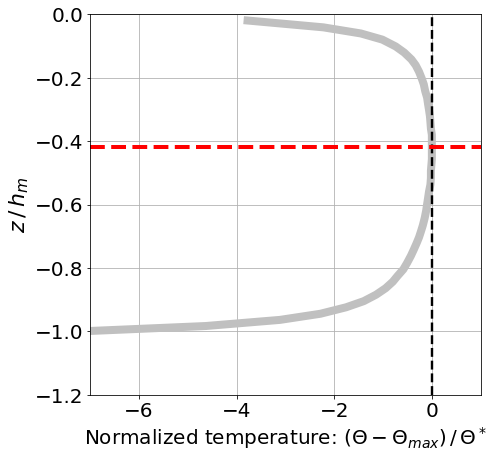

In [18]:
T_Tmax_Tstar_Mironov = np.array([-3.7783687943262407, -2.2278368794326235, -1.457446808510639, -1.0186170212765955, -0.7455673758865249, -0.5700354609929068, -0.42375886524822626, -0.335992907801419, -0.26773049645390046, -0.20921985815602895, -0.17021276595744617, -0.1409574468085104, -0.1019503546099294, -0.0824468085106389, -0.06294326241134662, -0.04343971631205612, -0.03368794326241087, -0.023936170212765617, -0.004432624113475114, -0.004432624113475114, -0.004432624113475114, -0.004432624113475114, -0.004432624113475114, -0.014184397163120366, -0.023936170212765617, -0.023936170212765617, -0.03368794326241087, -0.06294326241134662, -0.0824468085106389, -0.1019503546099294, -0.12145390070921991, -0.15070921985815566, -0.18971631205673667, -0.22872340425531945, -0.26773049645390046, -0.3164893617021267, -0.375, -0.4335106382978715, -0.5115248226950353, -0.5895390070921991, -0.7065602836879439, -0.8040780141843964, -0.9503546099290787, -1.1453900709219855, -1.3989361702127656, -1.7597517730496453, -2.286347517730496, -3.1152482269503547, -4.636524822695035, -7.73758865248227])
z_T_Mironov = np.array([-0.019354838709677358, -0.04086021505376336, -0.06021505376344072, -0.0795698924731183, -0.1010752688172043, -0.12043010752688166, -0.14193548387096766, -0.1602150537634408, -0.1806451612903226, -0.2032258064516128, -0.22043010752688164, -0.24193548387096775, -0.26236559139784943, -0.2827956989247311, -0.30107526881720426, -0.32150537634408594, -0.3397849462365591, -0.36021505376344076, -0.37956989247311823, -0.3989247311827957, -0.4193548387096774, -0.4376344086021505, -0.4569892473118279, -0.47526881720430103, -0.4935483870967742, -0.5161290322580645, -0.5365591397849462, -0.5591397849462365, -0.5795698924731182, -0.5989247311827957, -0.6193548387096773, -0.6419354838709677, -0.6655913978494623, -0.6849462365591398, -0.7032258064516128, -0.721505376344086, -0.7419354838709677, -0.7612903225806451, -0.7838709677419354, -0.8043010752688171, -0.8247311827956989, -0.843010752688172, -0.8634408602150537, -0.8838709677419354, -0.9043010752688172, -0.9236559139784946, -0.9440860215053763, -0.9634408602150537, -0.9827956989247312, -1.0032258064516129])

plt.figure(figsize=(7,7))
plt.plot( T_Tmax_Tstar_Mironov, z_T_Mironov,linewidth=8,color='silver')
plt.ylim(-1.2,0)
plt.xlim(-7,1)
plt.axvline(x=0, linestyle='--', color='black',linewidth=2.4)
plt.axhline(y=-0.4185, linestyle='--', color='red',linewidth=4)
plt.xlabel(r"Normalized temperature: $(\Theta - \Theta_{max}) \, / \, \Theta^*$", fontsize = 20)
plt.ylabel(r"$ z \, / \, h_m$", fontsize = 22)
plt.gca().yaxis.set_tick_params(labelsize = 20)
plt.gca().xaxis.set_tick_params(labelsize = 20)
plt.grid()

### For determining the exact position of dzdT = 0
#dTdz_Mironov = (T_Tmax_Tstar_Mironov[1:] - T_Tmax_Tstar_Mironov[0:-1]) / (z_T_Mironov[1:] - z_T_Mironov[0:-1])
#z_middle = (z_T_Mironov[1:] + z_T_Mironov[0:-1])/2
#plt.plot(z_middle,dTdz_Mironov)
#plt.axhline(y=0,color='black',linestyle='--')
#plt.axvline(x=-0.4185,color='black',linestyle='--')
#plt.ylim(-5,5)

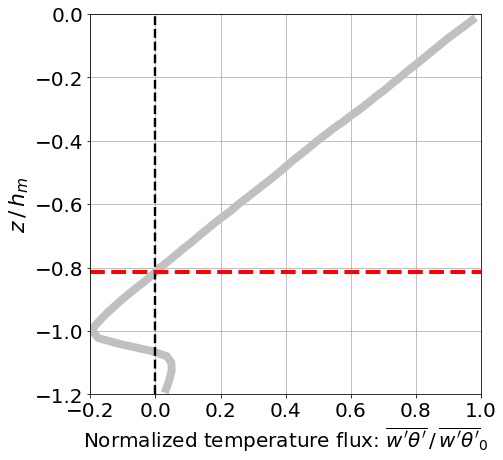

In [19]:
wT_wstarTstar_Mironov = np.array([0.03285302593659942, 0.03976945244956773, 0.045533141210374634, 0.050144092219020164, 0.04899135446685879, 0.035158501440922196, -0.014409221902017294, -0.1043227665706052, -0.17463976945244958, -0.1942363112391931, -0.18501440922190202, -0.16541786743515852, -0.1469740634005764, -0.1250720461095101, -0.10317002881844381, -0.07896253602305477, -0.05475504322766572, -0.03170028818443804, -0.007492795389048984, 0.013256484149855918, 0.03861671469740635, 0.06282420749279538, 0.08587896253602306, 0.10893371757925074, 0.13314121037463977, 0.15619596541786746, 0.1815561959654179, 0.20576368876080692, 0.23112391930835735, 0.2564841498559078, 0.27953890489913547, 0.30489913544668584, 0.3302593659942363, 0.3544668587896254, 0.37752161383285304, 0.40172910662824207, 0.4247838616714698, 0.45014409221902024, 0.47435158501440927, 0.4997118155619597, 0.5250720461095102, 0.5469740634005764, 0.5757925072046111, 0.6011527377521615, 0.6276657060518733, 0.6541786743515849, 0.6783861671469742, 0.7025936599423632, 0.7256484149855909, 0.7521613832853027, 0.7752161383285303, 0.7994236311239193, 0.8247838616714698, 0.8501440922190202, 0.8731988472622478, 0.8985590778097983, 0.9239193083573487, 0.9492795389048991, 0.9734870317002884])
z_wT_Mironov  = np.array([-1.1829181494661922, -1.1637010676156583, -1.1434163701067614, -1.1241992882562277, -1.099644128113879, -1.079359430604982, -1.0622775800711743, -1.0419928825622775, -1.0227758007117438, -0.999288256227758, -0.9822064056939501, -0.9608540925266904, -0.9416370106761566, -0.9213523131672599, -0.901067615658363, -0.8807829181494662, -0.8604982206405694, -0.8423487544483985, -0.8209964412811388, -0.800711743772242, -0.7804270462633451, -0.7601423487544484, -0.7398576512455517, -0.7217081850533809, -0.700355871886121, -0.6811387900355872, -0.6597864768683275, -0.6405693950177936, -0.6213523131672598, -0.5989323843416371, -0.5807829181494663, -0.5604982206405694, -0.5402135231316726, -0.5209964412811389, -0.501779359430605, -0.4804270462633452, -0.4601423487544485, -0.43985765124555165, -0.4195729537366548, -0.3982206405693951, -0.37900355871886127, -0.36085409252669043, -0.3405693950177937, -0.3202846975088969, -0.30106761565836304, -0.2797153024911033, -0.2594306049822065, -0.24128113879003565, -0.22099644128113882, -0.199644128113879, -0.17935943060498238, -0.16014234875444844, -0.13879003558718872, -0.117437722419929, -0.09822064056939506, -0.07686832740213534, -0.057651245551601615, -0.03843416370106767, -0.019217081850533946])

plt.figure(figsize=(7,7))
plt.plot( wT_wstarTstar_Mironov, z_wT_Mironov,linewidth=8,color='silver')
plt.axvline(x=0,color='black',linestyle='--',linewidth=2.4)
plt.axhline(y=-0.813,color='red',linestyle='--',linewidth=4)
plt.ylim(-1.2,0)
plt.xlim(-0.2,1)
plt.xlabel(r"Normalized temperature flux: $\overline{w' \theta'} \, / \, \overline{w' \theta'}_0$", fontsize = 20)
plt.ylabel(r"$ z \, / \, h_m$", fontsize = 22)
plt.gca().yaxis.set_tick_params(labelsize = 20)
plt.gca().xaxis.set_tick_params(labelsize = 20)
plt.grid()


### Figure 2 

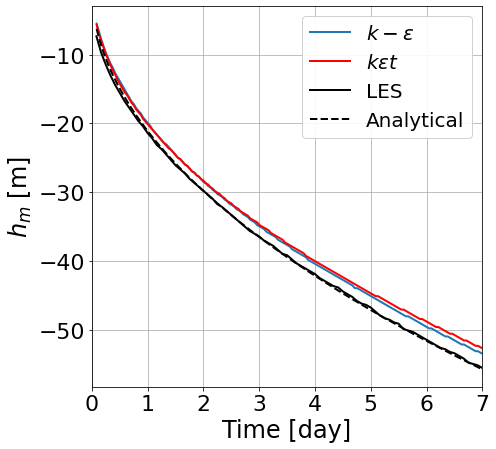

In [20]:
plt.figure(figsize=(7,7))
plt.plot(t_days[2:], MLD[2:,i_Keps_DG],linewidth=2,color='tab:blue',label=r"$k-\varepsilon$")
plt.plot(t_days[2:], MLD[2:,i_Keps_DGNG],color='red',linewidth=2,label=r"$k \varepsilon t$")
plt.plot(t_LES_days[1:], MLD_LES[1:], label='LES',linewidth=2,color='black')

MLD_FC = -np.sqrt(2.8 * -B0 * t_seconds[2:]/N2)
plt.plot(t_days[2:],MLD_FC,linestyle='--',label='Analytical',linewidth=2,color='black')
plt.legend(fontsize = 20,framealpha=0.9)
plt.xticks([0,1,2,3,4,5,6,7])
plt.xlabel('Time [day]', fontsize = 24)
plt.ylabel(r"$h_m$ [m]", fontsize = 24)
plt.gca().yaxis.set_tick_params(labelsize = 22)
plt.gca().xaxis.set_tick_params(labelsize = 22)
plt.xlim(0,7)
plt.grid()


### Figure 3

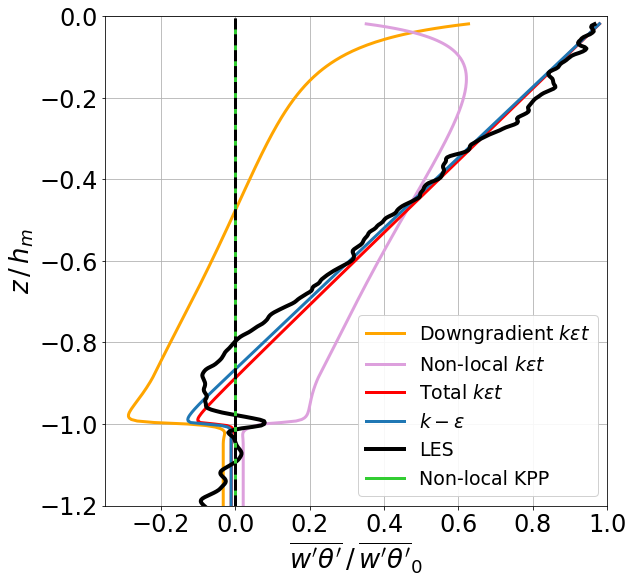

In [21]:
timeC=24*7   
plt.figure(figsize=(9,9))
plt.plot(wT_DG[:-5,timeC,i_Keps_DGNG]/-fnet_Cms, z_w[:-5]/-MLD[timeC,i_Keps_DGNG],linewidth=3,color='orange',label=r'Downgradient $k \varepsilon t$')
plt.plot(wT_NG[:-5,timeC,i_Keps_DGNG]/-fnet_Cms, z_w[:-5]/-MLD[timeC,i_Keps_DGNG],linewidth=3,color='plum',label=r'Non-local $k \varepsilon t$')
plt.plot(wT[:-5,timeC,i_Keps_DGNG]/-fnet_Cms, z_w[:-5]/-MLD[timeC,i_Keps_DGNG],linewidth=3,color='red',label=r'Total $k \varepsilon t$')
plt.plot(wT[:-5,timeC,i_Keps_DG]/-fnet_Cms, z_w[:-5]/-MLD[timeC,i_Keps_DG],color='tab:blue',linewidth=3,label=r"$k-\varepsilon$")
plt.plot(wT_LES[:-5,int(timeC/2)]/-fnet_Cms, z_r_LES[:-5]/-MLD_LES[int(timeC/2)],linewidth=4,color='black',label='LES')
plt.plot(wT_NG[:-5,timeC,i_KPP]/-fnet_Cms, z_w[:-5]/-MLD[timeC,i_KPP],linewidth=3,color='limegreen',label=r'Non-local KPP')

plt.ylim(-1.2,0)
plt.xlim(-0.35,1)
plt.xticks([-0.2,0,0.2,0.4,0.6,0.8,1])
plt.gca().yaxis.set_tick_params(labelsize = 24)
plt.gca().xaxis.set_tick_params(labelsize = 24)
plt.xlabel(r"$\overline{w' \theta'} \, / \, \overline{w' \theta'}_0$", fontsize = 26)
plt.ylabel(r"$ z \, / \, h_m$", fontsize = 26)
plt.grid()
plt.axvline(x=0, linestyle='--', color='black',linewidth=3)
plt.legend(fontsize=19,framealpha=0.9)


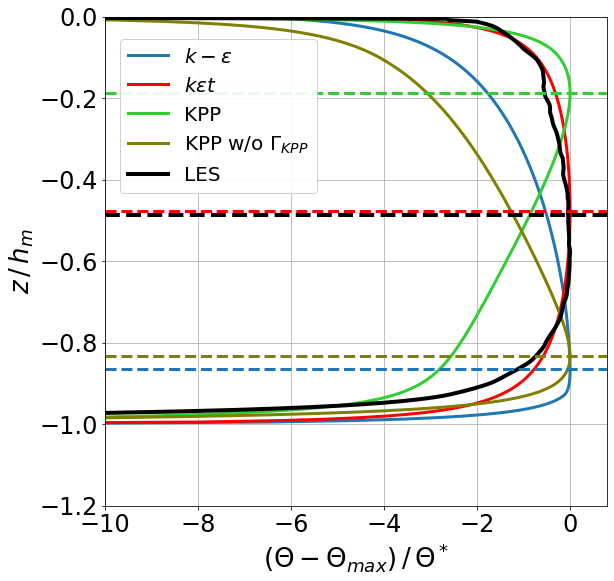

In [22]:
timeC=24*7
plt.figure(figsize=(9,9))

profiles         = (T[:,timeC,:]-np.max(T[:,timeC,:],axis=0)) / Tstar[timeC,:]
z_profiles       = z_r_N_sch / -MLD[timeC,:]

plt.plot( profiles[:,i_Keps_DG], z_profiles[:,i_Keps_DG],linewidth=3,color='tab:blue',label=r"$k-\varepsilon$")
plt.plot( profiles[:,i_Keps_DGNG], z_profiles[:,i_Keps_DGNG],linewidth=3,color='red',label=r"$k \varepsilon t$")
plt.plot( profiles[:,i_KPP], z_profiles[:,i_KPP],linewidth=3,color='limegreen',label='KPP')
plt.plot( profiles[:,i_KPPwoNL], z_profiles[:,i_KPPwoNL],linewidth=3,color='olive',label=r'KPP w/o $\Gamma_{KPP}$')
plt.plot( (T_LES[:,int(timeC/2)]-np.max(T_LES[:,int(timeC/2)]))/Tstar_LES[int(timeC/2)] ,z_r_LES/-MLD_LES[int(timeC/2)],linewidth=4,color='black',label='LES')

plt.ylim(-1.2,0)
plt.xlim(-10,0.8)

plt.axhline(y=z_dTdz0[timeC,i_Keps_DG]/-MLD[timeC,i_Keps_DG], linestyle='--', color='tab:blue',linewidth=3)
plt.axhline(y=z_dTdz0[timeC,i_Keps_DGNG]/-MLD[timeC,i_Keps_DGNG], linestyle='--', color='red',linewidth=3)
plt.axhline(y=z_dTdz0[timeC,i_KPP]/-MLD[timeC,i_KPP], linestyle='--', color='limegreen',linewidth=3)
plt.axhline(y=z_dTdz0[timeC,i_KPPwoNL]/-MLD[timeC,i_KPPwoNL], linestyle='--', color='olive',linewidth=3)  # small shift just for seeing the line
plt.axhline(y=z_dTdz0_LES[int(timeC/2)]/-MLD_LES[int(timeC/2)], linestyle='--', color='black',linewidth=4)

plt.xlabel(r"$(\Theta - \Theta_{max}) \, / \, \Theta^*$", fontsize = 26)
plt.ylabel(r"$ z \, / \, h_m$", fontsize = 26)
plt.gca().yaxis.set_tick_params(labelsize = 24)
plt.gca().xaxis.set_tick_params(labelsize = 24)
plt.grid()
plt.legend(loc=[0.03,0.64],framealpha=0.9,fontsize = 20)


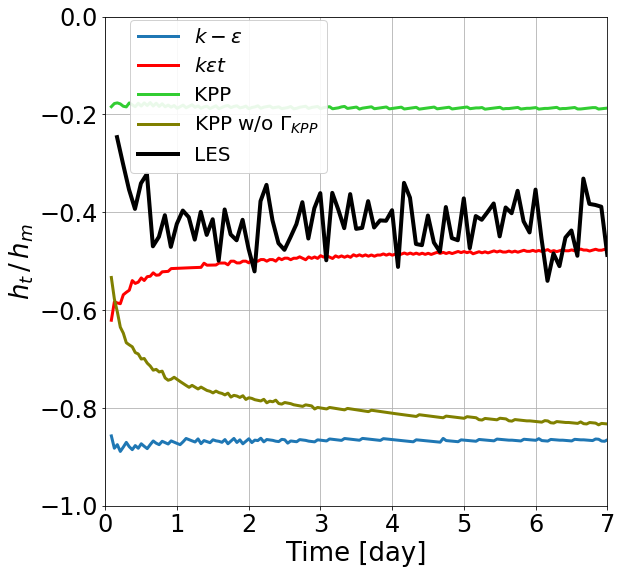

In [23]:
plt.figure(figsize=(9,9))
plt.plot(t_days[2:], z_dTdz0[2:,i_Keps_DG]/-MLD[2:,i_Keps_DG],linewidth=3,color='tab:blue',label=r"$k-\varepsilon$")
plt.plot(t_days[2:], z_dTdz0[2:,i_Keps_DGNG]/-MLD[2:,i_Keps_DGNG],linewidth=3,color='red',label=r"$k \varepsilon t$")
plt.plot(t_days[2:], z_dTdz0[2:,i_KPP]/-MLD[2:,i_KPP],linewidth=3,color='limegreen',label='KPP')
plt.plot(t_days[2:], z_dTdz0[2:,i_KPPwoNL]/-MLD[2:,i_KPPwoNL],linewidth=3,color='olive',label=r'KPP w/o $\Gamma_{KPP}$')
plt.plot(t_LES_days[2:], z_dTdz0_LES[2:]/-MLD_LES[2:], label='LES',linewidth=4,color='black')
plt.grid()

plt.xlabel('Time [day]', fontsize = 26)
plt.ylabel(r"$h_t \, / \, h_m$", fontsize = 26)
plt.gca().yaxis.set_tick_params(labelsize = 24)
plt.gca().xaxis.set_tick_params(labelsize = 24)
plt.ylim(-1,0)
plt.xlim(0,7)
plt.xticks([0,1,2,3,4,5,6,7])

plt.legend(loc=[0.05,0.68],framealpha=0.9,fontsize=20)


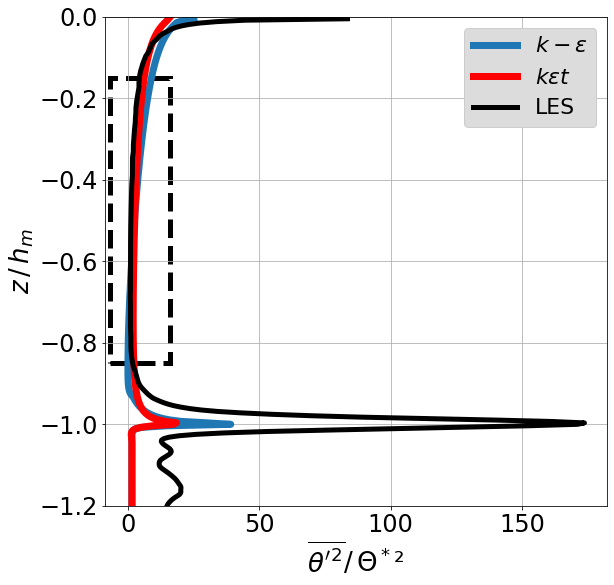

In [24]:
timeC=24*7
plt.figure(figsize=(9,9))

profiles         = varT[:-1,timeC,:] / Tstar[timeC,:]**2
z_profiles       = z_w_N_sch[:-1,:]/-MLD[timeC,:]

plt.plot( profiles[:,i_Keps_DG], z_profiles[:,i_Keps_DG],linewidth=7,color='tab:blue',label=r"$k-\varepsilon$")
plt.plot( profiles[:,i_Keps_DGNG], z_profiles[:,i_Keps_DGNG],linewidth=7,color='red',label=r"$k \varepsilon t$")
plt.plot( varT_LES[:-1,int(timeC/2)]/Tstar_LES[int(timeC/2)]**2, z_r_LES[:-1]/-MLD_LES[int(timeC/2)],linewidth=5,color='black',label='LES')

plt.ylim(-1.2,0)
plt.xlabel(r"$\overline{\theta'^2} / \, \Theta^*²$", fontsize = 26)
plt.ylabel(r"$ z \, / \, h_m$", fontsize = 26)
plt.gca().yaxis.set_tick_params(labelsize = 24)
plt.gca().xaxis.set_tick_params(labelsize = 24)
autoscale()
plt.legend(fontsize = 22,framealpha=1,facecolor='gainsboro')
plt.grid()

plt.gca().add_patch(matplotlib.patches.Rectangle(xy=[-7, -0.85], width=23, height=0.7,
                                    fill=False,
                                    edgecolor='k',
                                    linewidth=5,
                                    linestyle='--'))


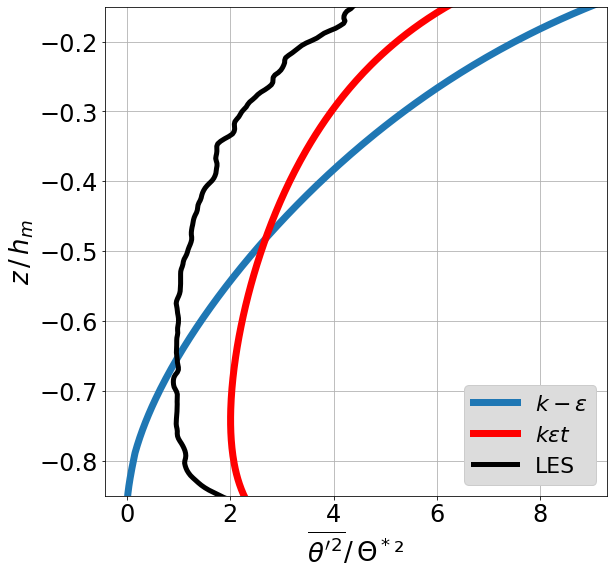

In [25]:
timeC=24*7
plt.figure(figsize=(9,9))

profiles         = varT[:-1,timeC,:] / Tstar[timeC,:]**2
z_profiles       = z_w_N_sch[:-1,:]/-MLD[timeC,:]

plt.plot( profiles[:,i_Keps_DG], z_profiles[:,i_Keps_DG],linewidth=7,color='tab:blue',label=r"$k-\varepsilon$")
plt.plot( profiles[:,i_Keps_DGNG], z_profiles[:,i_Keps_DGNG],linewidth=7,color='red',label=r"$k \varepsilon t$")
plt.plot( varT_LES[:-1,int(timeC/2)]/Tstar_LES[int(timeC/2)]**2, z_r_LES[:-1]/-MLD_LES[int(timeC/2)],linewidth=5,color='black',label='LES')

plt.ylim(-0.85,-0.15)
plt.xlabel(r"$\overline{\theta'^2} / \, \Theta^*²$", fontsize = 26)
plt.ylabel(r"$ z \, / \, h_m$", fontsize = 26)
plt.gca().yaxis.set_tick_params(labelsize = 24)
plt.gca().xaxis.set_tick_params(labelsize = 24)
autoscale()
plt.legend(fontsize = 22,framealpha=1,facecolor='gainsboro')
plt.grid()



### Figure C1

In [26]:
Fh_keps = Fh / (1. + cT*Fh_star*Alpha_n)
residual = 2.*wT*dTdz + 2./cT*Eps/TKE*varT

wT_DG_diag = - TKE**2/Eps * Fh_keps * dTdz
wT_NG_diag = cT/2. * (9.81*alpha) * TKE**2/Eps**2 * Fh_star/(1.+cT*Fh_star*Alpha_n) * residual

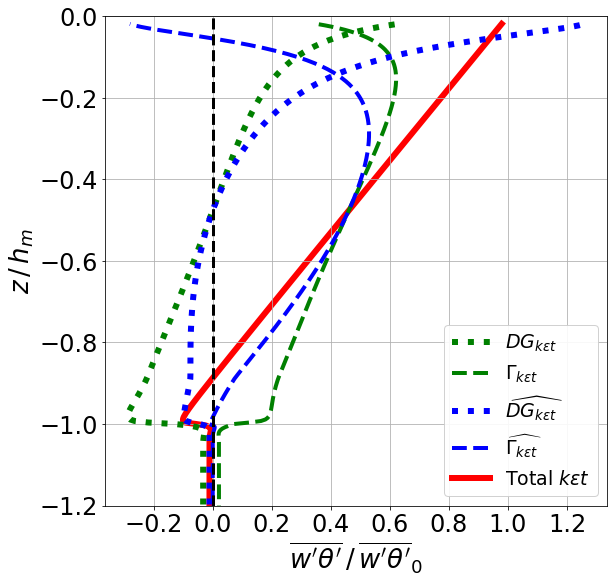

In [27]:
timeC=24*7   
plt.figure(figsize=(9,9))
plt.plot(wT_DG[:-5,timeC,i_Keps_DGNG]/-fnet_Cms, z_w[:-5]/-MLD[timeC,i_Keps_DGNG],linestyle=':',linewidth=6,color='green',label=r'$DG_{k \varepsilon t}$')
plt.plot(wT_NG[:-5,timeC,i_Keps_DGNG]/-fnet_Cms, z_w[:-5]/-MLD[timeC,i_Keps_DGNG],linestyle='--',linewidth=4,color='green',label=r'$\Gamma_{k \varepsilon t}$')

plt.plot(wT_DG_diag[:-5,timeC,i_Keps_DGNG]/-fnet_Cms, z_w[:-5]/-MLD[timeC,i_Keps_DGNG],linestyle=':',color='blue',linewidth=6,label=r'$\widehat{DG_{k \varepsilon t}}$',zorder=2)
plt.plot(wT_NG_diag[:-5,timeC,i_Keps_DGNG]/-fnet_Cms, z_w[:-5]/-MLD[timeC,i_Keps_DGNG],linestyle='--',color='blue',linewidth=4,label=r'$\widehat{\Gamma_{k \varepsilon t}}$')

plt.plot(wT[:-5,timeC,i_Keps_DGNG]/-fnet_Cms, z_w[:-5]/-MLD[timeC,i_Keps_DGNG],linewidth=6,color='red',label=r'Total $k \varepsilon t$',zorder=1)

plt.ylim(-1.2,0)
plt.xticks([-0.2,0,0.2,0.4,0.6,0.8,1,1.2])
plt.gca().yaxis.set_tick_params(labelsize = 24)
plt.gca().xaxis.set_tick_params(labelsize = 24)
plt.xlabel(r"$\overline{w' \theta'} \, / \, \overline{w' \theta'}_0$", fontsize = 26)
plt.ylabel(r"$ z \, / \, h_m$", fontsize = 26)
plt.grid()
plt.axvline(x=0, linestyle='--', color='black',linewidth=3)
plt.legend(fontsize=19,framealpha=0.9)
